In [1]:
import pandas as pd
from modules import Agent,Model
from DCAStrategy import DCAAgent
from LSStrategy import LSSAgent
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


Start Trading

In [2]:
symbol = "FPT"

In [3]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [4]:
df.tail

<bound method NDFrame.tail of             Date     Close      Open      High       Low
0     2014-01-14    9429.7    9410.6    9563.9    9391.4
1     2014-01-15    9583.0    9506.4    9870.5    9487.2
2     2014-01-16    9678.9    9774.7    9774.7    9583.0
3     2014-01-17    9870.5    9774.7   10062.2    9678.9
4     2014-01-20    9966.4    9870.5   10253.9    9870.5
...          ...       ...       ...       ...       ...
2591  2024-06-10  144000.0  143500.0  145000.0  143000.0
2592  2024-06-11  146500.0  144300.0  146500.0  143100.0
2593  2024-06-12  132000.0  127900.0  132700.0  127800.0
2594  2024-06-13  130000.0  133700.0  133800.0  130000.0
2595  2024-06-14  131000.0  130000.0  132500.0  129000.0

[2596 rows x 5 columns]>

Trade without LSTM

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
initial_money = np.max(parameters[0]) * 3
skip = 1
from_date ="2024-04-06"
to_date = "2024-06-14"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [6]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [7]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]


In [8]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [9]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,112600.0,439500.0,2024-06-16 19:54:32.141348,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,113000.0,439500.0,2024-06-16 19:54:32.141348,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,113800.0,439500.0,2024-06-16 19:54:32.141348,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,114900.0,439500.0,2024-06-16 19:54:32.141348,2024-04-11,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,115500.0,439500.0,2024-06-16 19:54:32.141348,2024-04-12,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,111600.0,439500.0,2024-06-16 19:54:32.141348,2024-04-15,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,113000.0,439500.0,2024-06-16 19:54:32.143664,2024-04-16,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,111800.0,439500.0,2024-06-16 19:54:32.143664,2024-04-17,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,109000.0,439500.0,2024-06-16 19:54:32.143664,2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,110300.0,439500.0,2024-06-16 19:54:32.159697,2024-04-22,439500.0,NaN,NaN,NaN,NaN,NaN


In [10]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

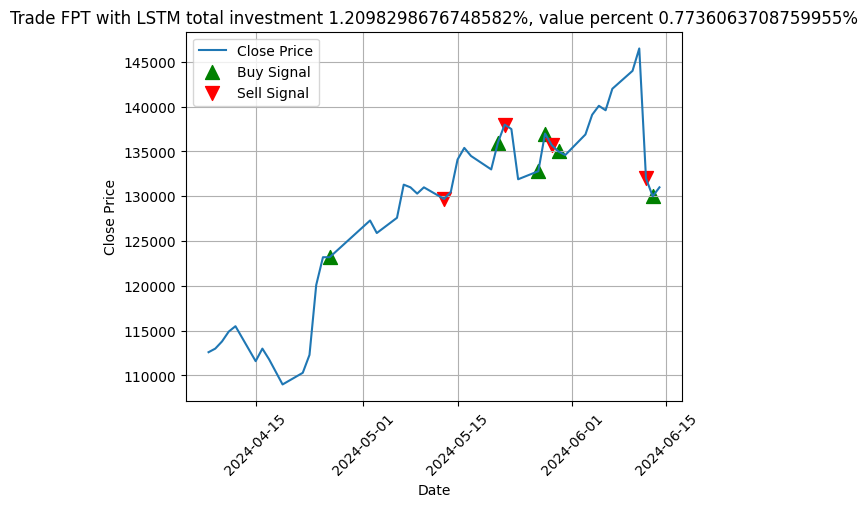

In [11]:

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%, value percent {investmentvalue}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

With LSTM

In [12]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 3
minmax = pickle.load(open(f"checkpoint/{symbol}prediction_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}prediction_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [13]:
agent2 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [14]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent2.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[9.31590569e-98 0.00000000e+00 1.00000000e+00]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[6.26875301e-76 0.00000000e+00 1.00000000e+00]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]


In [15]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [16]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,112600.0,439500.0,2024-06-16 19:54:32.788225,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,113000.0,439500.0,2024-06-16 19:54:32.788225,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,113800.0,439500.0,2024-06-16 19:54:32.788225,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,114900.0,439500.0,2024-06-16 19:54:32.788225,2024-04-11,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,115500.0,439500.0,2024-06-16 19:54:32.788225,2024-04-12,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,111600.0,439500.0,2024-06-16 19:54:32.788225,2024-04-15,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,113000.0,439500.0,2024-06-16 19:54:32.788225,2024-04-16,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,111800.0,439500.0,2024-06-16 19:54:32.788225,2024-04-17,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,109000.0,439500.0,2024-06-16 19:54:32.788225,2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN
9,"buy 1 unit, cost 110300.000000",1,110300.0,329200.0,2024-06-16 19:54:32.790776,2024-04-22,439500.0,NaN,NaN,NaN,NaN,NaN


In [17]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

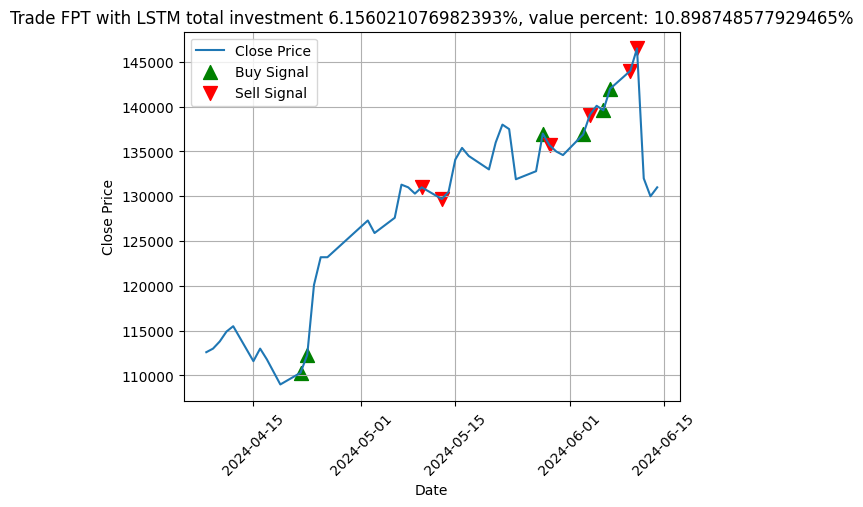

In [18]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%, value percent: {investmentvalue}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA without LSTM

In [19]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [20]:
agent3 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [21]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent3.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[9.99986749e-01 0.00000000e+00 1.32506171e-05]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[3.17103213e-197 1.00000000e+000 0.00000000e+000]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [22]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [23]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,total_gain,total_sold
0,data not enough to trade,0,112600.0,732500.0,2024-06-16 19:54:33.471070,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:33.471070,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,113800.0,732500.0,2024-06-16 19:54:33.471070,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,114900.0,732500.0,2024-06-16 19:54:33.471070,2024-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,115500.0,732500.0,2024-06-16 19:54:33.471070,2024-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,111600.0,732500.0,2024-06-16 19:54:33.472222,2024-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:33.472222,2024-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,111800.0,732500.0,2024-06-16 19:54:33.472222,2024-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,109000.0,732500.0,2024-06-16 19:54:33.472222,2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,110300.0,732500.0,2024-06-16 19:54:33.473731,2024-04-22,732500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

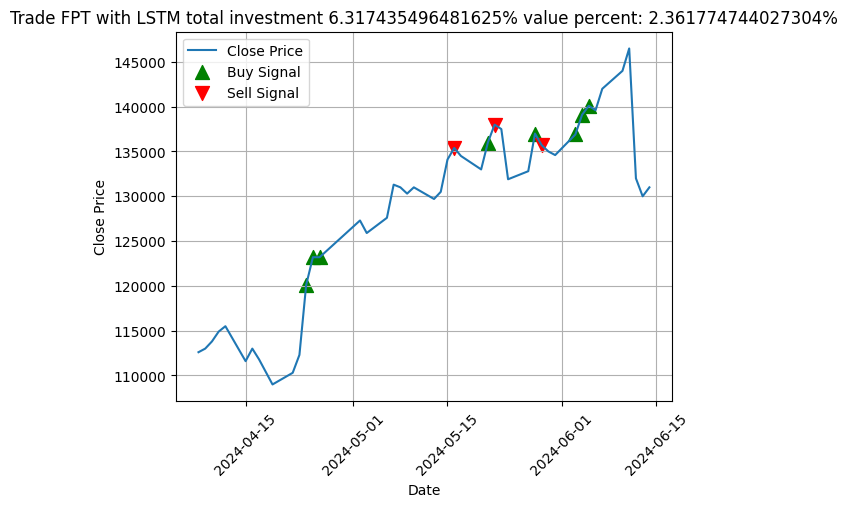

In [25]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}% value percent: {investmentvalue}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

In [26]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [27]:
agent4 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [28]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent4.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [29]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 112600.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.062353',
  'date': '2024-04-08'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 113000.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.063777',
  'date': '2024-04-09'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 113800.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.063777',
  'date': '2024-04-10'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 114900.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.064802',
  'date': '2024-04-11'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 115500.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.064802',
  'date': '2024-04-12'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 111600.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:34.064802',
  'date': '

In [30]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [31]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,total_gain,total_sold
0,data not enough to trade,0,112600.0,732500.0,2024-06-16 19:54:34.062353,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:34.063777,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,113800.0,732500.0,2024-06-16 19:54:34.063777,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,114900.0,732500.0,2024-06-16 19:54:34.064802,2024-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,115500.0,732500.0,2024-06-16 19:54:34.064802,2024-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,111600.0,732500.0,2024-06-16 19:54:34.064802,2024-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:34.064802,2024-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,111800.0,732500.0,2024-06-16 19:54:34.066276,2024-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,109000.0,732500.0,2024-06-16 19:54:34.066276,2024-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"buy 1 unit, cost 110300.000000",1,110300.0,622200.0,2024-06-16 19:54:34.068458,2024-04-22,732500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

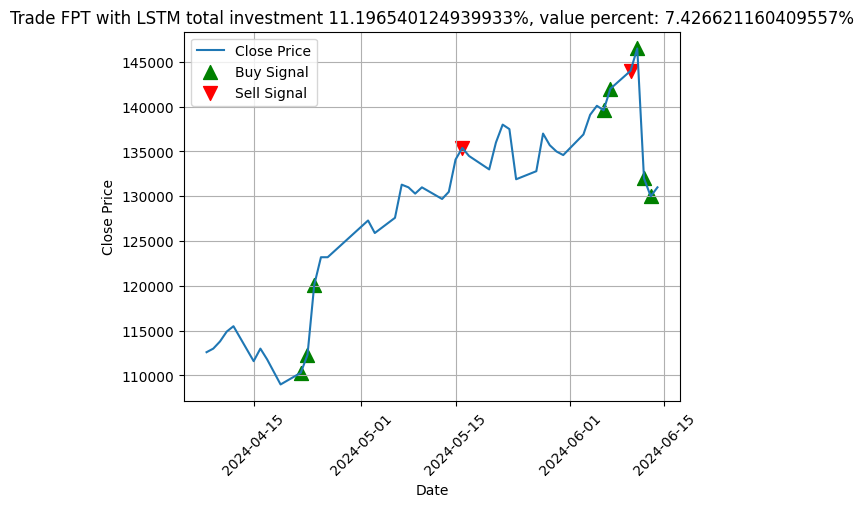

In [33]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%, value percent: {investmentvalue}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITHOUT LSTM


In [34]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [35]:
df.tail

<bound method NDFrame.tail of            Date     Close  pct_change  log_change            7ma  \
21   2014-02-21   11116.3    0.017538    0.017386   10959.628500   
22   2014-02-24   11403.8    0.025863    0.025534   11070.820133   
23   2014-02-25   11787.2    0.033620    0.033068   11250.094983   
24   2014-02-26   12362.1    0.048773    0.047621   11528.305603   
25   2014-02-27   12074.6   -0.023257   -0.023531   11664.956329   
...         ...       ...         ...         ...            ...   
2591 2024-06-10  144000.0    0.014085    0.013986  140166.881130   
2592 2024-06-11  146500.0    0.017361    0.017212  141750.160847   
2593 2024-06-12  132000.0   -0.098976   -0.104224  139312.620635   
2594 2024-06-13  130000.0   -0.015152   -0.015267  136984.465477   
2595 2024-06-14  131000.0    0.007692    0.007663  135488.349107   

               14ma           21ma        7macd       14macd       7rsi  ...  \
21     10806.684047   10715.604409  -204.008519  -198.569202  57.140727  

In [36]:
agent5 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [37]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent5.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0.00000000e+000 1.48506749e-225 1.00000000e+000]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]


In [38]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 112600.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.100197',
  'date': '2024-04-08'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 113000.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.101192',
  'date': '2024-04-09'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 113800.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.101192',
  'date': '2024-04-10'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 114900.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.101192',
  'date': '2024-04-11'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 115500.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.101192',
  'date': '2024-04-12'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 111600.0,
  'balance': 732500.0,
  'timestamp': '2024-06-16 19:54:35.101192',
  'date': '

In [39]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [40]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

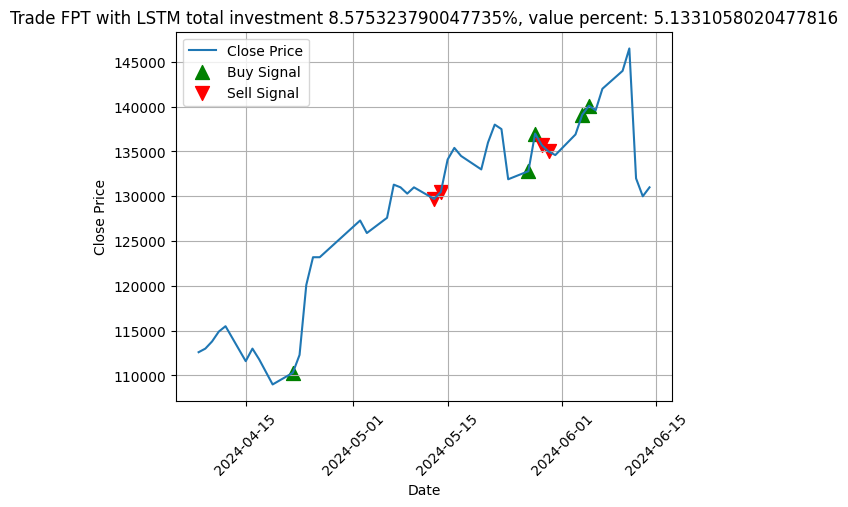

In [41]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}%, value percent: {investmentvalue}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITH LSTM

In [42]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = np.max(parameters[0]) * 5
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [43]:
agent6 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [44]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent6.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [45]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [46]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,gain
0,data not enough to trade,0,112600.0,732500.0,2024-06-16 19:54:35.731451,2024-04-08,NaN,NaN,NaN,NaN
1,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:35.731451,2024-04-09,NaN,NaN,NaN,NaN
2,data not enough to trade,0,113800.0,732500.0,2024-06-16 19:54:35.731451,2024-04-10,NaN,NaN,NaN,NaN
3,data not enough to trade,0,114900.0,732500.0,2024-06-16 19:54:35.731451,2024-04-11,NaN,NaN,NaN,NaN
4,data not enough to trade,0,115500.0,732500.0,2024-06-16 19:54:35.731451,2024-04-12,NaN,NaN,NaN,NaN
5,data not enough to trade,0,111600.0,732500.0,2024-06-16 19:54:35.732828,2024-04-15,NaN,NaN,NaN,NaN
6,data not enough to trade,0,113000.0,732500.0,2024-06-16 19:54:35.732828,2024-04-16,NaN,NaN,NaN,NaN
7,data not enough to trade,0,111800.0,732500.0,2024-06-16 19:54:35.732828,2024-04-17,NaN,NaN,NaN,NaN
8,data not enough to trade,0,109000.0,732500.0,2024-06-16 19:54:35.732828,2024-04-19,NaN,NaN,NaN,NaN
9,"buy 3 units, cost 330900.0",1,110300.0,401600.0,2024-06-16 19:54:35.734031,2024-04-22,732500.0,NaN,NaN,NaN


In [47]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
if(df_action_2[df_action_2.columns[0]].count()== 0):
    last_total_investment = 0
else:
    last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100

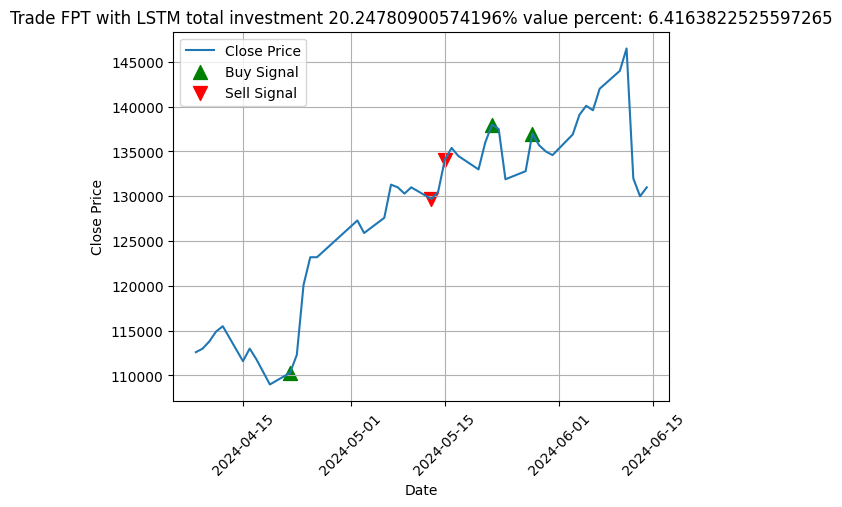

In [48]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} with LSTM total investment {last_total_investment}% value percent: {investmentvalue}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()